In [ ]:
%matplotlib inline
import sklearn, tflearn, sys, os
import tensorflow as tf, os, csv, sqlite3, pandas as pd, numpy as np, codecs, re, traceback, math, pickle
import matplotlib.pyplot as plt
cpAry = ["D:/Python/Anaconda/notebook"]
[sys.path.insert(0, cp) for cp in cpAry if cp not in sys.path]

from contextlib import closing
from sklearn.utils import shuffle
from sklearn import metrics, preprocessing

exec(open("D:/Python/Anaconda/notebook/utils/utils.py").read())
np.set_printoptions(precision=7, suppress=True, linewidth=200)

In [2]:
ctxPath = 'D:/Python/Anaconda/notebook'

def connect():
    return sqlite3.connect('mp.sqlite')

class MpData:
    def __init__(self):
        self.data = {}
        self.yVal = 1.
        self.nVal = -1.
        self.scaler = preprocessing.StandardScaler()
    
    def queryBatch(self, sql, batch=2000):
        with closing(connect()) as conn, closing(conn.cursor()) as cur:
            cur.execute(sql)
            cache, cnt, cols = [], 0, None
            while True:
                r = cur.fetchone()
                if r is None:
                    break
                if cols is None:
                    cols = np.array(cur.description)[:, 0]
                    
                row_, r = [], np.array(r)
                for x, e in enumerate(r):
                    try:
                        row_.append(float(e))
                    except:
                        row_.append(1 if e == 'Y' else -1)
                cache.append(row_)
                if (cnt + 1) % batch == 0:
                    yield cols, np.array(cache)
                    del cache[:]
                cnt += 1
        if len(cache):
            yield cols, np.array(cache)
            del cache[:]
    
    def query(self, sql, scaler, norm=True):
        cache = []
        for cols, data in self.queryBatch(sql, batch=2000):
            cache.append(data)
        cache = np.vstack(cache)
        if norm:
            cache = np.c_[cache[:, 0], scaler.transform(cache[:, 1:-1]), cache[:, -1]]
        return cache

    def minibatches(self, key, isTrans=False, batch=100, shuffle=False, rest=True):
        data = self.data[key] if isinstance(key, str) else key
        x, y = self.transform(data) if isTrans else data
        for idx in minibatchesIdx(len(x), batch, shuffle=shuffle):
            yield x[idx], y[idx]
            
def findData(date, targetTab):
    return pd.DataFrame(mp.query("""
        select * 
          from mp_{} a 
         where exists (select 1 
                         from {} b 
                        where a.subscr_id = b.subscr_id)""".format(date, targetTab), mp.scaler, norm=False))\
    .sort_values(0)\
    .reset_index(drop=True)
    
def iterData(data, batch, epLim=1):
    if type(data) in (tuple, list):
        x, y = data
        idAry = minibatchesIdx(len(x), batch)
        # print(len(idAry), idAry[-1])
        epCnt = 0
        while True:
            if epLim is not None and epCnt >= epLim: break
            for idx in idAry:
                yield x[idx], y[idx]
            epCnt += 1

# prepare data

In [3]:
mp = MpData()
# mp.scaler = loadVar('/'.join([ctxPath, 'scaler_mp_201508.pkl']))

+ 資料加上時間軸

In [4]:
trlist = (findData('201507', 'train_subs'), findData('201508', 'train_subs'), findData('201509', 'train_subs'), findData('201510', 'train_subs'))
trX = np.stack((trlist[-1].iloc[:, 1:-1].values, trlist[-2].iloc[:, 1:-1].values, trlist[-3].iloc[:, 1:-1].values, trlist[-4].iloc[:, 1:-1].values), 2)
trY = np.array([[0., 1.] if e == 1 else [1., 0.] for e in trlist[-1].iloc[:, -1]])

In [5]:
telist = (findData('201603', 'test_subs'), findData('201604', 'test_subs'), findData('201605', 'test_subs'), findData('201606', 'test_subs'))
teX = np.stack((telist[-1].iloc[:, 1:-1].values, telist[-2].iloc[:, 1:-1].values, telist[-3].iloc[:, 1:-1].values, telist[-4].iloc[:, 1:-1].values), 2)
teY = np.array([[0., 1.] if e == 1 else [1., 0.] for e in telist[-1].iloc[:, -1]])

+ 對資料做正規化(StandardScaler)

In [6]:
trX = trX.reshape(trX.shape[0], -1)
teX = teX.reshape(teX.shape[0], -1)

scaler = preprocessing.StandardScaler()
trX = scaler.fit_transform(trX)
teX = scaler.transform(teX)
with open("smcaler_201510.pkl", "wb") as w:
    pickle.dump(scaler, w)
    
trX.shape, trY.shape, teX.shape, teY.shape

((100000, 656), (100000, 2), (100000, 656), (100000, 2))

+ 加上 mp nes 變數, subscr_id會減少, 100000 => 97859 

In [7]:
nesSql = """
select * from mp_nes_{} a
 where exists (select 1 from {}
                where subscr_id = a.subscr_id)
 order by a.subscr_id
"""
with closing(connect()) as conn:
    trNesDf = pd.read_sql(nesSql.format("201510", "train_subs"), conn).astype(np.float64, copy=False)
    teNesDf = pd.read_sql(nesSql.format("201606", "test_subs"), conn).astype(np.float64, copy=False)
# 
trConds = trlist[-1].iloc[:, 0].isin(trNesDf["SUBSCR_ID"])
teConds = telist[-1].iloc[:, 0].isin(teNesDf["SUBSCR_ID"])

# 去除不存在nes subIds的records
trNesX, trNesY = trX.reshape(trX.shape[0], -1)[trConds], trY[trConds]
teNesX, teNesY = teX.reshape(teX.shape[0], -1)[teConds], teY[teConds]

# 堆疊nes變數在原本data後方(nes資料在sql中已經處理, 只留下交集的subIds)
# nes標籤, 消費筆數, 消費金額 各24個欄位(72), 配合原資料4個月 = 16週(大約), 每個變數各取前16個欄位
ind = np.array([e for pos in range(1, 73, 24) for e in range(pos, pos + 16)])
trNesX = np.c_[trNesX, trNesDf.values[:, ind]]
teNesX = np.c_[teNesX, teNesDf.values[:, ind]]

+ 對加上nes之後的資料做正規化

In [8]:
nesScaler = preprocessing.StandardScaler()
trNesX = nesScaler.fit_transform(trNesX)
teNesX = nesScaler.transform(teNesX)
with open("scaler_nes_201510.pkl", "wb") as w:
    pickle.dump(nesScaler, w)

trNesX.shape, trNesY.shape, teNesX.shape, teNesY.shape

((97859, 704), (97859, 2), (99172, 704), (99172, 2))

## keras dnn

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling2D, Conv2D, MaxPooling1D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from contextlib import closing
from sklearn.utils import shuffle
from sklearn import metrics, preprocessing

Using TensorFlow backend.


In [16]:
from keras.backend import tensorflow_backend as tfbk
def buildModel(shape):
    # 清除graph的快取, 否則變數的index會一直累加
    tfbk.reset_uids()
    model = Sequential()
    model.add(Dense(512, input_dim=shape))
    model.add(Activation('softplus'))
    # model.add(Dropout(0.4))
    model.add(Dense(128))
    model.add(Activation('softplus'))
    model.add(Dense(64))
    model.add(Activation('softplus'))
    # model.add(Dropout(0.4))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    '''setting optimizer'''
    learning_rate = 0.001
    optimizer = Adam(learning_rate)
    # sgd = SGD(lr=learning_rate, decay=learning_decay, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # check parameters of every layers
    model.summary()
    return model

def buildNesModel(shape):
    return buildModel(shape)

def train(model, trX, trY, teX, teY):
    batch, nEpoch = 200, 5
    hist = model.fit_generator(iterData((trX, trY), batch=batch, epLim=nEpoch + 1), 
                                  samples_per_epoch=trX.shape[0], nb_epoch=nEpoch)
    trPred = model.predict(trX)
    rpt(trY, trPred, 'train')

    tePred = model.predict(teX)
    rpt(teY, tePred, 'test')
    return hist


+ training without nes variable

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           336384      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 128)           65664       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 128)           0           dense_2[0][0]                    
___________________________________________________________________________________________

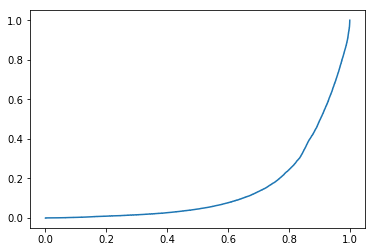


test
-------------------------------------------------------
       0      1
0  31375  10722
1  13427  44476
             precision    recall  f1-score   support

          0       0.70      0.75      0.72     42097
          1       0.81      0.77      0.79     57903

avg / total       0.76      0.76      0.76    100000

gini coef: 0.6595420760793591


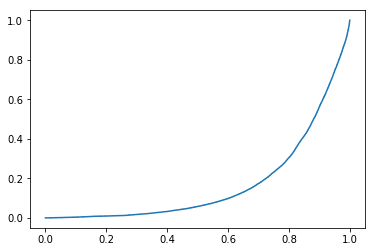

In [17]:
model = buildModel(trX[0].shape[0])
hist = train(model, trX, trY, teX, teY)

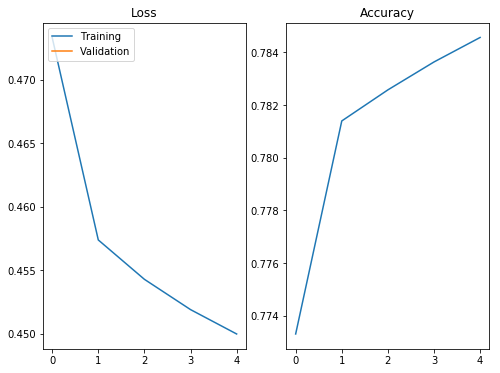

In [26]:
showHistory(hist)
# hist.history

+ training with nes variables

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           360960      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 128)           65664       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 128)           0           dense_2[0][0]                    
___________________________________________________________________________________________

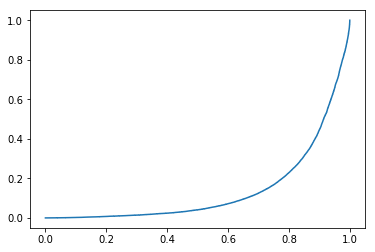


test
-------------------------------------------------------
       0      1
0  29794  12077
1  11419  45882
             precision    recall  f1-score   support

          0       0.72      0.71      0.72     41871
          1       0.79      0.80      0.80     57301

avg / total       0.76      0.76      0.76     99172

gini coef: 0.6753055727926423


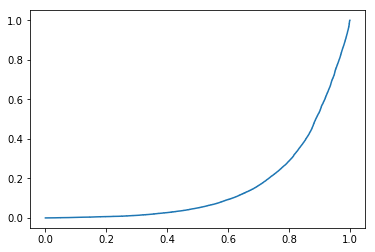

In [28]:
nesModel = buildNesModel(trNesX[0].shape[0])
train(nesModel, trNesX, trNesY, teNesX, teNesY)

# tflearn

Training Step: 2450  | total loss: 0.46536 | time: 3.268s
| Adam | epoch: 005 | loss: 0.46536 - acc: 0.7760 -- iter: 97859/97859
train
-------------------------------------------------------
       0      1
0  27868   8678
1  11825  49488
             precision    recall  f1-score   support

          0       0.70      0.76      0.73     36546
          1       0.85      0.81      0.83     61313

avg / total       0.80      0.79      0.79     97859

gini coef: 0.7323016562325337


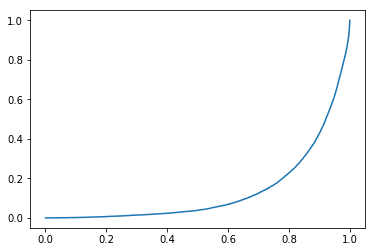


test
-------------------------------------------------------
       0      1
0  31482  10389
1  12435  44866
             precision    recall  f1-score   support

          0       0.72      0.75      0.73     41871
          1       0.81      0.78      0.80     57301

avg / total       0.77      0.77      0.77     99172

gini coef: 0.6967425553222979


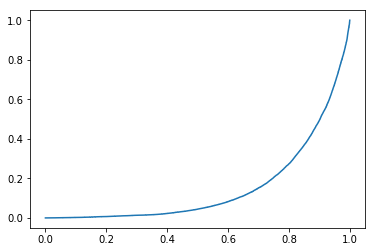

In [103]:
k = 'tflearn_train'
ctx = '/'.join(['dnn', k])
outfname = '/'.join([ctx, 'dnn_mp_model.ckpt'])
historyPath = '/'.join([ctx, 'dnn_mp_model_history.pkl'])
logdir = '/'.join(['logs/dnn', k])
try:
    if not os.path.exists(ctx):
        os.makedirs(ctx)
    os.unlink(outfname)
except:
    pass

def tflearnTrain(traindata, testData):
    x, y = traindata
    tx, ty = testData
    # Graph definition
    tf.reset_default_graph()
    with tf.Graph().as_default():
        net = tflearn.input_data(shape=[None, 728])
        # net = tflearn.fully_connected(net, 64, activation='softplus')
        # net = tflearn.fully_connected(net, 32, activation='softplus')
        # net = tflearn.fully_connected(net, 32, activation='softplus')
        # net = tflearn.fully_connected(net, 16, activation='softplus')
        net = tflearn.fully_connected(net, 512, activation='softplus')
        net = tflearn.fully_connected(net, 128, activation='softplus')
        net = tflearn.fully_connected(net, 64, activation='softplus')
        net = tflearn.fully_connected(net, 2, activation='softmax')
        net = tflearn.regression(net, optimizer='adam', batch_size=200, learning_rate=0.001, name='trainer')
        # Model training
        model = tflearn.DNN(net, tensorboard_dir=logdir)
        model.fit(x, y, n_epoch=5, snapshot_epoch=False, show_metric=True, run_id="tflearn_dnn_mp")

    trPred = model.predict(x)
    rpt(y, np.array(trPred), "train")

    tePred = model.predict(tx)
    rpt(ty, np.array(tePred), "test")
    
tflearnTrain((trNesX, trNesY), (teNesX, teNesY))

# DQN作法 (完全不行)

In [ ]:
# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=1,
            hidden_layers=[64, 32, 32, 16],
            replace_target_iter=300,
            memory_size=500,
            batch_size=100,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.hidden_layers = hidden_layers
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = pd.DataFrame(np.zeros((self.memory_size, n_features*2+2)))

        # consist of [target_net, evaluate_net]
        self._build_net()

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []
        self.accu_his = []

    def _build_net(self):
        # create eval and target net weights and biases separately
        self._eval_net_params = []
        self._target_net_params = []

        # build evaluate_net
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')
        self.y_ = tf.placeholder(tf.float32, [None, self.n_actions], name='y_')
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')
        with tf.variable_scope('eval_net'):
            self.q_eval = self._build_layers(self.s, self.n_actions, trainable=True)
            with tf.name_scope('loss'):
                self.loss = tf.reduce_sum(tf.square(self.q_target - self.q_eval))
            with tf.name_scope('train'):
                self._train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
            with tf.name_scope('test'):
                pred = tf.argmax(self.q_eval, 1)
                self.accuracy = tf.reduce_mean(tf.cast(tf.equal(pred, tf.argmax(self.y_, 1)), tf.float32), name="accuracy")

        # build target_net
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')
        with tf.variable_scope('target_net'):
            self.q_next = self._build_layers(self.s_, self.n_actions, trainable=False)

    def _build_layers(self, inputs, action_size, trainable):
        layers_output = [inputs]
        for i, n_unit in enumerate(self.hidden_layers):
            with tf.variable_scope('layer%i' % i):
                output = self._add_layer(
                    layers_output[i],
                    in_size=layers_output[i].get_shape()[1].value,
                    out_size=n_unit,
                    activation_function=tf.nn.relu,
                    trainable=trainable,
                )
                layers_output.append(output)
        with tf.variable_scope('output_layer'):
            output = self._add_layer(
                layers_output[-1],
                in_size=layers_output[-1].get_shape()[1].value,
                out_size=action_size,
                activation_function=None,
                trainable=trainable
            )
        return output

    def _add_layer(self, inputs, in_size, out_size, activation_function=None, trainable=True):
        # create weights and biases
        Weights = tf.get_variable(
            name='weights',
            shape=[in_size, out_size],
            trainable=trainable,
            initializer=tf.truncated_normal_initializer(mean=0., stddev=0.3)
        )
        biases = tf.get_variable(
            name='biases',
            shape=[out_size],
            initializer=tf.constant_initializer(0.1),
            trainable=trainable
        )

        # record parameters
        if trainable is True:
            self._eval_net_params.append([Weights, biases])
        else:
            self._target_net_params.append([Weights, biases])

        Wx_plus_b = tf.matmul(inputs, Weights) + biases

        # activation function
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b)
        return outputs

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory.iloc[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def _replace_target_params(self):
        replace_ops = []
        for layer, params in enumerate(self._eval_net_params):
            replace_op = [tf.assign(self._target_net_params[layer][W_b], params[W_b]) for W_b in range(2)]
            replace_ops.append(replace_op)
        self.sess.run(replace_ops)

    def learn(self, bcnt, y_):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self._replace_target_params()
            # print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        batch_memory = self.memory.sample(self.batch_size) \
            if self.memory_counter > self.memory_size \
            else self.memory.iloc[:self.memory_counter].sample(self.batch_size, replace=True)

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory.iloc[:, -self.n_features:],
                self.s: batch_memory.iloc[:, :self.n_features]
            })
        
        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()
        q_target[np.arange(self.batch_size, dtype=np.int32), batch_memory.iloc[:, self.n_features].astype(int)] = \
            batch_memory.iloc[:, self.n_features+1] + self.gamma * np.max(q_next, axis=1)

        """
        For example in this batch I have 2 samples and 3 actions:
        q_eval =
        [[1, 2, 3],
         [4, 5, 6]]
        q_target = q_eval =
        [[1, 2, 3],
         [4, 5, 6]]
        Then change q_target with the real q_target value w.r.t the q_eval's action.
        For example in:
            sample 0, I took action 0, and the max q_target value is -1;
            sample 1, I took action 2, and the max q_target value is -2:
        q_target =
        [[-1, 2, 3],
         [4, 5, -2]]
        So the (q_target - q_eval) become:
        [[(-1)-(1), 0, 0],
         [0, 0, (-2)-(6)]]
        We then backpropagate this error w.r.t the corresponded action to network,
        leave other action as error=0 cause we didn't choose it.
        """

        # train eval network
        _, cost, accu = self.sess.run([self._train_op, self.loss, self.accuracy],
                                     feed_dict={self.s: batch_memory.iloc[:, :self.n_features],
                                                self.q_target: q_target,
                                                self.y_: y_})
        self.cost_his.append(cost)
        self.accu_his.append(accu)
        if bcnt > 0 and bcnt % 50 == 0: print("\raccu = {}, cost = {}".format(accu, cost), end="")
        
        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his, c="r")
        plt.plot(np.arange(len(self.accu_his)), self.cost_his, c="b")
        plt.show()

In [ ]:
tf.reset_default_graph()
dqn = DeepQNetwork(2, trX.shape[1],
                  learning_rate=0.01,
                  reward_decay=0.9,
                  e_greedy=0.9,
                  hidden_layers=[10, 10],
                  replace_target_iter=200,
                  memory_size=2000,
                  # output_graph=True
                  )
for episode in range(5):
    this, nxt = None, None
    for bcnt, (bX, bY) in enumerate(mp.minibatches((trX, trY))):
        for x in range(1, len(bX), 2):
            rec, rec_ = bX[x - 1], bX[x]
            ans = bY[x - 1]
            # RL choose action based on observation
            action = dqn.choose_action(rec)
            # 答案對 reward = 1, 否則 -1            
            reward = 1 if np.argmax(ans) == action else -1
            dqn.store_transition(rec, action, reward, rec_)
        dqn.learn(bcnt, bY)